In [94]:
from __future__ import absolute_import, division, print_function,unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib.ticker import (MultipleLocator)


# Binary Classification with Sonar Dataset: Standardized Larger
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [95]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12198421289024639864
xla_global_id: -1
]


In [182]:
df_final= pd.read_excel('/Users/neharajput/Downloads/Alarm_Data_Model.xlsx')

In [183]:
df_final

,Date Timestamp,variable,Time_Diff,value
0,2019-01-15 00:36:51,AAH-3030,1565,0.0
1,2019-03-29 23:33:12,AAH-3030,6031,0.0
2,2019-04-02 09:33:34,AAH-3030,86,0.0
3,2019-04-02 09:36:10,AAH-3030,1916,0.0
4,2019-04-02 15:05:50,AAH-3030,20,0.0
...,...,...,...,...
83683,2020-10-24 05:46:00,ZA-3502,14678,0.0
83684,2020-10-24 09:51:14,ZA-3502,3058,0.0
83685,2020-10-24 20:48:13,ZA-3502,9247,0.0
83686,2020-10-25 04:29:52,ZA-3502,14,0.0


In [101]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83688 entries, 0 to 83687
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date Timestamp  83688 non-null  datetime64[ns]
 1   variable        83688 non-null  object        
 2   Time_Diff       83688 non-null  int64         
 3   value           83688 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.6+ MB


Renaming the column names of the dataframe

In [102]:
df_final.rename(columns = {'variable':'SO'}, inplace = True)
df_final.rename(columns = {'Time_Diff':'ATD'}, inplace = True)

In [103]:
df_final['Date Timestamp']=df_final['Date Timestamp'].astype(str)

Splitting the date timestamp into Year, Month, Day, Hour, Minute and Seconds

In [104]:
df1 = df_final['Date Timestamp'].str.split(expand=True)
df1.columns = ['D','T']
df_final = df_final.join(df1)

In [105]:
df_final['D'] = pd.to_datetime(df_final['D'])

In [106]:
df_final['day'] = df_final['D'].dt.day
df_final['month'] = df_final['D'].dt.month
df_final['year'] = df_final['D'].dt.year

In [107]:
df_final['Date Timestamp'] = pd.to_datetime(df_final['Date Timestamp'])

In [108]:
df_final['hour'] = df_final['Date Timestamp'].dt.hour
df_final['minute'] = df_final['Date Timestamp'].dt.minute
df_final['second'] = df_final['Date Timestamp'].dt.second

In [109]:
df_final.drop(['Date Timestamp', 'D','T'], axis = 1,inplace=True)

In [110]:
df_final.rename(columns = {'year':'Y','month':'M','day':'D','hour':'H','minute':'m',
                           'second':'s','value':'CHB'}, inplace = True)

In [111]:
df_final['Y']=df_final['Y'].astype(float)
df_final['Y']=df_final['Y'].astype(float)
df_final['D']=df_final['D'].astype(float)
df_final['H']=df_final['H'].astype(float)
df_final['m']=df_final['m'].astype(float)
df_final['s']=df_final['s'].astype(float)
df_final['ATD']=df_final['ATD'].astype(float)
df_final['CHB']=df_final['CHB'].astype(float)

Dropping the year column as year will not re occur in the future.

In [112]:
df_final.drop(['Y'], axis = 1,inplace=True)

In [113]:
df_final

,SO,ATD,CHB,D,M,H,m,s
0,AAH-3030,1565.0,0.0,15.0,1,0.0,36.0,51.0
1,AAH-3030,6031.0,0.0,29.0,3,23.0,33.0,12.0
2,AAH-3030,86.0,0.0,2.0,4,9.0,33.0,34.0
3,AAH-3030,1916.0,0.0,2.0,4,9.0,36.0,10.0
4,AAH-3030,20.0,0.0,2.0,4,15.0,5.0,50.0
...,...,...,...,...,...,...,...,...
83683,ZA-3502,14678.0,0.0,24.0,10,5.0,46.0,0.0
83684,ZA-3502,3058.0,0.0,24.0,10,9.0,51.0,14.0
83685,ZA-3502,9247.0,0.0,24.0,10,20.0,48.0,13.0
83686,ZA-3502,14.0,0.0,25.0,10,4.0,29.0,52.0


Adding the unit variable and assigning the units as per the alarm tag, for example, assigning Degree Celsius to all temperature alarm tags

In [114]:
result = []
for value in df_final['SO']:
    if value.startswith('PA') or value.startswith('PD') or value.startswith('PM'):
        result.append("kPag")
    elif value.startswith('TA'):
        result.append("Deg C")
    elif value.startswith('FA') or value.startswith('FA'):
        result.append("m3/h")
    elif value.startswith('LA') or value.startswith('LI') or value.startswith('LD'):
        result.append("mm")
    elif value.startswith('VA'):
        result.append("mm/s")
    elif value.startswith('AAH-3030') or value.startswith('AAHH-3030') or value.startswith('AAH-3040') or value.startswith('AAHH-3040'):
        result.append("ms")
    elif value.startswith('AAH-3032') or value.startswith('AAHH-3032') or value.startswith('AAH-3042') or value.startswith('AAHH-3042'):
        result.append("NTU")
    else:
        result.append("-")
df_final['UNI'] = result

In [115]:
from __future__ import absolute_import, division, print_function,unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib.ticker import (MultipleLocator)


# Binary Classification with Sonar Dataset: Standardized Larger
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [116]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

#code = np.array(df_train.SO)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(df_final.SO)
df_final.SO= pd.DataFrame(vec)
label_encoder1 = LabelEncoder()
vec = label_encoder1.fit_transform(df_final.UNI)
df_final.UNI= pd.DataFrame(vec)

In [117]:
df_train_test= df_final.copy()

Splitting the dataset into train and test

In [118]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_train_test, test_size=0.2)

In [119]:
df_train.reset_index(inplace=True,drop=True)
df_test.reset_index(inplace=True,drop=True)

CHB is the target variable, taking out the target variable from train and test both and assigning it to y_train and y_eval dataframe

In [120]:
y_train = df_train.pop('CHB')
y_eval = df_test.pop('CHB')

In [121]:
dataset_test = df_test.values

In [122]:
dataset_train = df_train.values

In [123]:
dataset_train

array([[6.400e+01, 2.680e+03, 2.500e+01, ..., 1.000e+00, 4.000e+01,
        4.000e+00],
       [9.700e+01, 5.670e+02, 6.000e+00, ..., 5.800e+01, 5.100e+01,
        0.000e+00],
       [1.940e+02, 1.738e+03, 1.600e+01, ..., 2.700e+01, 5.800e+01,
        5.000e+00],
       ...,
       [1.330e+02, 1.190e+02, 1.300e+01, ..., 3.000e+00, 1.500e+01,
        5.000e+00],
       [1.820e+02, 8.000e+00, 2.300e+01, ..., 4.000e+01, 7.000e+00,
        5.000e+00],
       [6.300e+01, 9.550e+02, 1.500e+01, ..., 0.000e+00, 1.800e+01,
        4.000e+00]])

In [124]:
CATEGORICAL_COLUMNS = ['SO','UNI']
NUMERIC_COLUMNS = ['Y', 'M', 'D', 'H', 'm', 's', 'ATD']

feature_columns = []
categorical_feature = [] 
# categorical, must be mapped into dense
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df_train[feature_name].unique()
    categorical_feature.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

In [125]:
for cat_col in categorical_feature:
    feature_columns.append(tf.feature_column.indicator_column(cat_col))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float64))

In [126]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

In [127]:
from sklearn.metrics import classification_report
def confusion_matrix_fnc(y,y_pred):

    cm = confusion_matrix(y, y_pred)

    print('Confusion matrix\n\n', cm)

    print('\nTrue Positives(TP) = ', cm[0,0])

    print('\nTrue Negatives(TN) = ', cm[1,1])

    print('\nFalse Positives(FP) = ', cm[0,1])

    print('\nFalse Negatives(FN) = ', cm[1,0])

    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0', 'Actual Positive:1'], 
                                     index=['Predict Negative:0', 'Predict Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

    print(classification_report(y, y_pred))

In [128]:
X_train=dataset_train
X_test=dataset_test

# Model 1 : Logistic Regression


In [129]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression


# instantiate the model
logreg = LogisticRegression( solver='lbfgs', max_iter=1000,random_state=1234)


# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1234)

In [130]:
y_pred_test = logreg.predict(X_test)

In [131]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_eval, y_pred_test)))

Model accuracy score: 0.8270


In [132]:
y_pred_train = logreg.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8334


Confusion matrix

 [[13788    83]
 [ 2812    55]]

True Positives(TP) =  13788

True Negatives(TN) =  55

False Positives(FP) =  83

False Negatives(FN) =  2812
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90     13871
         1.0       0.40      0.02      0.04      2867

    accuracy                           0.83     16738
   macro avg       0.61      0.51      0.47     16738
weighted avg       0.76      0.83      0.76     16738



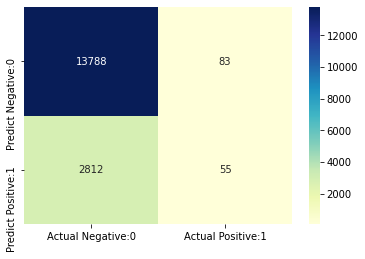

In [133]:
confusion_matrix_fnc(y_eval,y_pred_test)

For Test:
Precision: 40%
Recall: 2%

Confusion matrix

 [[55591   335]
 [10819   205]]

True Positives(TP) =  55591

True Negatives(TN) =  205

False Positives(FP) =  335

False Negatives(FN) =  10819
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     55926
         1.0       0.38      0.02      0.04     11024

    accuracy                           0.83     66950
   macro avg       0.61      0.51      0.47     66950
weighted avg       0.76      0.83      0.77     66950



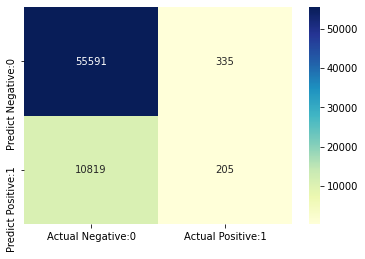

In [134]:
confusion_matrix_fnc(y_train,y_pred_train)

For Train:
Precision: 38%
Recall: 2%

Applying SMOTE as it seems to be an imbalanced dataset and see if precision and recall improves

# Model 2: Logistic Regression with SMOTE

In [135]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 11024
Before OverSampling, counts of label '0': 55926 

After OverSampling, the shape of train_X: (111852, 8)
After OverSampling, the shape of train_y: (111852,) 

After OverSampling, counts of label '1': 55926
After OverSampling, counts of label '0': 55926


In [136]:
# instantiate the model
logreg_smote = LogisticRegression(  max_iter=1000,random_state=1234)


# fit the model
logreg_smote.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=1234)

In [137]:
y_pred_test_res = logreg_smote.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_eval, y_pred_test_res)))

Model accuracy score: 0.6535


In [138]:
y_pred_train_res = logreg_smote.predict(X_train_res)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train_res, y_pred_train_res)))

Training-set accuracy score: 0.7620


Confusion matrix

 [[8255 5616]
 [ 184 2683]]

True Positives(TP) =  8255

True Negatives(TN) =  2683

False Positives(FP) =  5616

False Negatives(FN) =  184
              precision    recall  f1-score   support

         0.0       0.98      0.60      0.74     13871
         1.0       0.32      0.94      0.48      2867

    accuracy                           0.65     16738
   macro avg       0.65      0.77      0.61     16738
weighted avg       0.87      0.65      0.70     16738



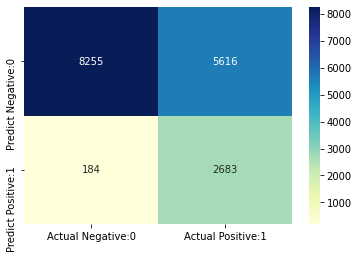

In [139]:
confusion_matrix_fnc(y_eval,y_pred_test_res)

For Test:
Precision: 32%
Recall: 94%

Since there is a trade off between precision and recall, Recall is drastically improved from 2% to 94% but precision is dropped from 38% to 32%

Confusion matrix

 [[32967 22959]
 [ 3665 52261]]

True Positives(TP) =  32967

True Negatives(TN) =  52261

False Positives(FP) =  22959

False Negatives(FN) =  3665
              precision    recall  f1-score   support

         0.0       0.90      0.59      0.71     55926
         1.0       0.69      0.93      0.80     55926

    accuracy                           0.76    111852
   macro avg       0.80      0.76      0.75    111852
weighted avg       0.80      0.76      0.75    111852



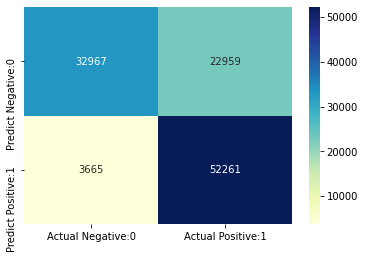

In [140]:
confusion_matrix_fnc(y_train_res, y_pred_train_res)

For Train: Precision: 69% 
Recall: 93%

# Tuning Logistic Regression model




Tuning the hyper parameters to see if model's accuracy is affected with L2 Regularization

In [141]:

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [142]:
lr_tuned = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr_tuned, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_res, y_train_res)


In [143]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.762984 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.762975 (0.004131) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.762058 (0.003966) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761003 (0.004501) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.762975 (0.004131) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.762105 (0.004196) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.760895 (0.004399) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.762975 (0.004131) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761897 (0.004247) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761363 (0.004377) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.762984 (0.004125) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.762067 (0.004223) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761259 (0.004267) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.762970 (0.004125) wit

In [144]:
lr_smote_tuned=grid_result.best_estimator_

In [145]:
y_pred_train_grid = grid_result.best_estimator_.predict(X_train_res)

Confusion matrix

 [[33211 22715]
 [ 3792 52134]]

True Positives(TP) =  33211

True Negatives(TN) =  52134

False Positives(FP) =  22715

False Negatives(FN) =  3792
              precision    recall  f1-score   support

         0.0       0.90      0.59      0.71     55926
         1.0       0.70      0.93      0.80     55926

    accuracy                           0.76    111852
   macro avg       0.80      0.76      0.76    111852
weighted avg       0.80      0.76      0.76    111852



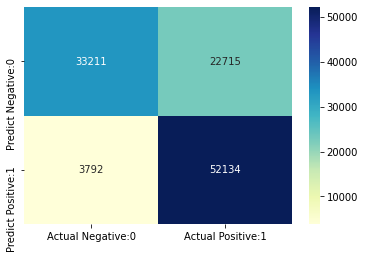

In [146]:
confusion_matrix_fnc(y_train_res,y_pred_train_grid)

For Train:
Precision: 70%
Recall: 93%

In [147]:
y_pred_test_grid=grid_result.best_estimator_.predict(X_test)

Confusion matrix

 [[8317 5554]
 [ 190 2677]]

True Positives(TP) =  8317

True Negatives(TN) =  2677

False Positives(FP) =  5554

False Negatives(FN) =  190
              precision    recall  f1-score   support

         0.0       0.98      0.60      0.74     13871
         1.0       0.33      0.93      0.48      2867

    accuracy                           0.66     16738
   macro avg       0.65      0.77      0.61     16738
weighted avg       0.87      0.66      0.70     16738



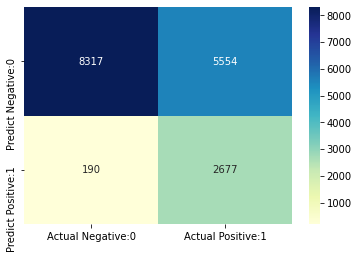

In [148]:
confusion_matrix_fnc(y_eval,y_pred_test_grid)

For Test:
Precision: 33%
Recall: 93%

# Ensemble models

In [149]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [150]:
kfold = StratifiedKFold(n_splits=10)

In [151]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [152]:
ytrain=encoded_Y

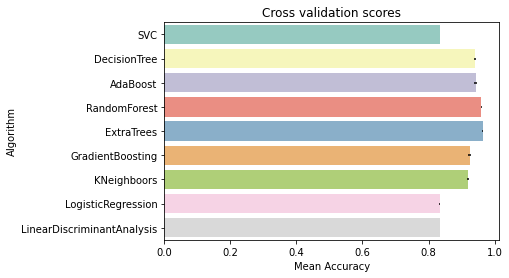

In [153]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = ytrain, scoring = "accuracy", cv = kfold, n_jobs=8))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# Model 3: Extra Tree Classifier

In [154]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [15,10],
              "max_features": [3,5],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 3],
              "bootstrap": [False],
              "n_estimators" :[100,120],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


0.954129947722181

Extra Tree Classifier Accuracy: 95.4%

In [155]:
ExtC_best

ExtraTreesClassifier(max_depth=15, max_features=5, min_samples_split=3,
                     n_estimators=120)

Confusion matrix

 [[55164   762]
 [ 1560  9464]]

True Positives(TP) =  55164

True Negatives(TN) =  9464

False Positives(FP) =  762

False Negatives(FN) =  1560
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     55926
         1.0       0.93      0.86      0.89     11024

    accuracy                           0.97     66950
   macro avg       0.95      0.92      0.94     66950
weighted avg       0.96      0.97      0.96     66950



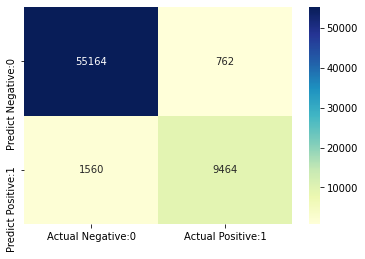

In [156]:
confusion_matrix_fnc(y_train,pd.Series(ExtC_best.predict(X_train)))

For Train:
Precision: 93%
Recall: 86%

Confusion matrix

 [[13611   260]
 [  527  2340]]

True Positives(TP) =  13611

True Negatives(TN) =  2340

False Positives(FP) =  260

False Negatives(FN) =  527
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13871
         1.0       0.90      0.82      0.86      2867

    accuracy                           0.95     16738
   macro avg       0.93      0.90      0.91     16738
weighted avg       0.95      0.95      0.95     16738



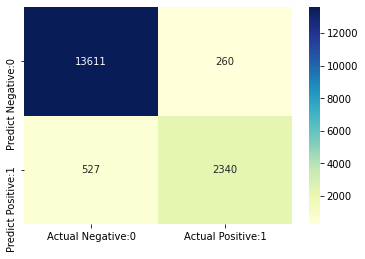

In [157]:
confusion_matrix_fnc(y_eval,pd.Series(ExtC_best.predict(X_test)))

For Test:
Precision: 90%
Recall: 82%

# Model 4: Random Forest

In [158]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5,10],
              "max_features": [1, 3],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 3],
              "bootstrap": [False],
              "n_estimators" :[100,200],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8,verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


0.9438386855862584

In [159]:
RFC_best

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=3,
                       min_samples_split=3, n_estimators=200)

Confusion matrix

 [[54756  1170]
 [ 2083  8941]]

True Positives(TP) =  54756

True Negatives(TN) =  8941

False Positives(FP) =  1170

False Negatives(FN) =  2083
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     55926
         1.0       0.88      0.81      0.85     11024

    accuracy                           0.95     66950
   macro avg       0.92      0.90      0.91     66950
weighted avg       0.95      0.95      0.95     66950



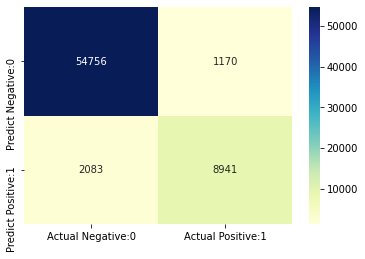

In [161]:
confusion_matrix_fnc(y_train,pd.Series(RFC_best.predict(X_train)))

For Train:
Precision: 88%
Recall: 81%

Confusion matrix

 [[13549   322]
 [  608  2259]]

True Positives(TP) =  13549

True Negatives(TN) =  2259

False Positives(FP) =  322

False Negatives(FN) =  608
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13871
         1.0       0.88      0.79      0.83      2867

    accuracy                           0.94     16738
   macro avg       0.92      0.88      0.90     16738
weighted avg       0.94      0.94      0.94     16738



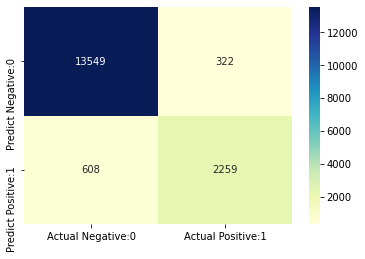

In [162]:
confusion_matrix_fnc(y_eval,pd.Series(RFC_best.predict(X_test)))

For Test:
Precision: 88%
Recall: 79%

# Gradient Boosting Classifier

In [163]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'learning_rate': [0.2,0.5,0.1],
              'min_samples_leaf': [50,100,150],
              'max_features': [0.5,0.7] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


0.9423749066467513

In [164]:
GBC_best

GradientBoostingClassifier(learning_rate=0.5, max_features=0.7,
                           min_samples_leaf=50)

Confusion matrix

 [[54381  1545]
 [ 2130  8894]]

True Positives(TP) =  54381

True Negatives(TN) =  8894

False Positives(FP) =  1545

False Negatives(FN) =  2130
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     55926
         1.0       0.85      0.81      0.83     11024

    accuracy                           0.95     66950
   macro avg       0.91      0.89      0.90     66950
weighted avg       0.94      0.95      0.94     66950



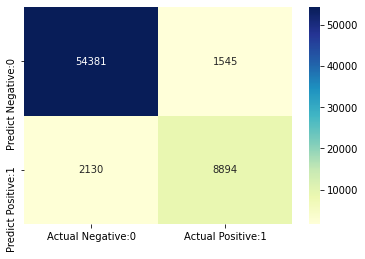

In [165]:
confusion_matrix_fnc(y_train,pd.Series(GBC_best.predict(X_train)))

For Train:
Precision: 85%
Recall: 81%

Confusion matrix

 [[13458   413]
 [  570  2297]]

True Positives(TP) =  13458

True Negatives(TN) =  2297

False Positives(FP) =  413

False Negatives(FN) =  570
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     13871
         1.0       0.85      0.80      0.82      2867

    accuracy                           0.94     16738
   macro avg       0.90      0.89      0.89     16738
weighted avg       0.94      0.94      0.94     16738



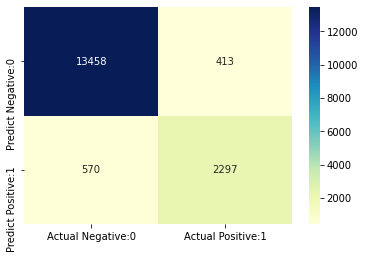

In [166]:
confusion_matrix_fnc(y_eval,pd.Series(GBC_best.predict(X_test)))

For Test:
Precision: 85%
Recall: 80%

# All Ensemble Voting Classifier

In [167]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),('gbc',GBC_best)], voting='soft', n_jobs=8)

votingC = votingC.fit(X_train, y_train)

Confusion matrix

 [[54888  1038]
 [ 1909  9115]]

True Positives(TP) =  54888

True Negatives(TN) =  9115

False Positives(FP) =  1038

False Negatives(FN) =  1909
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     55926
         1.0       0.90      0.83      0.86     11024

    accuracy                           0.96     66950
   macro avg       0.93      0.90      0.92     66950
weighted avg       0.96      0.96      0.96     66950



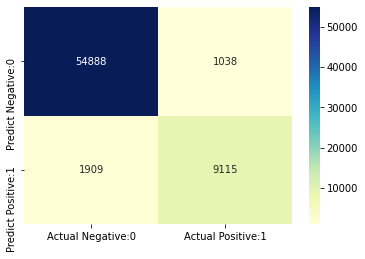

In [168]:
confusion_matrix_fnc(y_train,pd.Series(votingC.predict(X_train)))

For Train:
Precision: 90%
Recall: 83%

Confusion matrix

 [[13587   284]
 [  551  2316]]

True Positives(TP) =  13587

True Negatives(TN) =  2316

False Positives(FP) =  284

False Negatives(FN) =  551
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13871
         1.0       0.89      0.81      0.85      2867

    accuracy                           0.95     16738
   macro avg       0.93      0.89      0.91     16738
weighted avg       0.95      0.95      0.95     16738



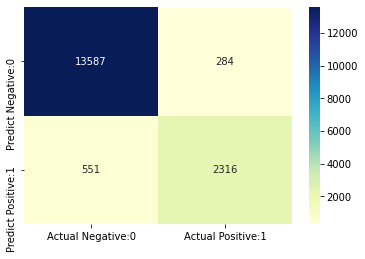

In [169]:
confusion_matrix_fnc(y_eval,pd.Series(votingC.predict(X_test)))

For Test:
Precision: 89%
Recall: 81%

# Learning Curves

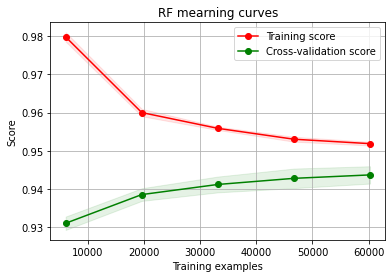

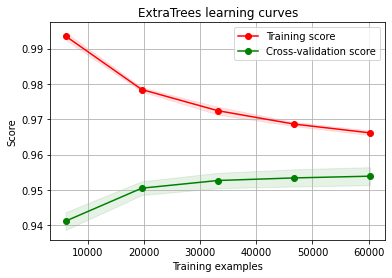

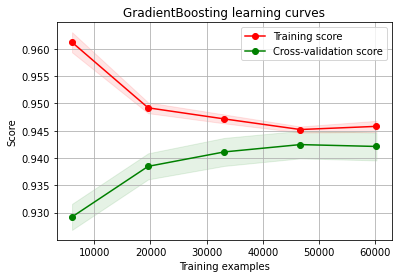

In [170]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

# Model 7: Keras RNN Model

In [171]:
dataset_y = df_train_test.pop('CHB')

encoder = LabelEncoder()
encoder.fit(dataset_y)
encoded_Y = encoder.transform(dataset_y)

dataset_X = df_train_test.values




In [172]:
dataset_X

array([[0.000e+00, 1.565e+03, 1.500e+01, ..., 3.600e+01, 5.100e+01,
        7.000e+00],
       [0.000e+00, 6.031e+03, 2.900e+01, ..., 3.300e+01, 1.200e+01,
        7.000e+00],
       [0.000e+00, 8.600e+01, 2.000e+00, ..., 3.300e+01, 3.400e+01,
        7.000e+00],
       ...,
       [7.020e+02, 9.247e+03, 2.400e+01, ..., 4.800e+01, 1.300e+01,
        0.000e+00],
       [7.020e+02, 1.400e+01, 2.500e+01, ..., 2.900e+01, 5.200e+01,
        0.000e+00],
       [7.020e+02, 5.510e+02, 2.500e+01, ..., 4.000e+01, 3.700e+01,
        0.000e+00]])

In [173]:
model = Sequential()
model.add(Dense(1024, input_dim=8, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [174]:
model.fit(dataset_X, encoded_Y, epochs=20)

Epoch 1/20
2616/2616 [==============================] - 10s 3ms/step - loss: 0.4858 - accuracy: 0.8398
Epoch 2/20
2616/2616 [==============================] - 9s 3ms/step - loss: 0.3436 - accuracy: 0.8513
Epoch 3/20
2616/2616 [==============================] - 9s 4ms/step - loss: 0.2848 - accuracy: 0.8655
Epoch 4/20
2616/2616 [==============================] - 9s 4ms/step - loss: 0.2782 - accuracy: 0.8694
Epoch 5/20
2616/2616 [==============================] - 9s 4ms/step - loss: 0.2676 - accuracy: 0.8737
Epoch 6/20
2616/2616 [==============================] - 9s 4ms/step - loss: 0.2602 - accuracy: 0.8777
Epoch 7/20
2616/2616 [==============================] - 10s 4ms/step - loss: 0.2538 - accuracy: 0.8834
Epoch 8/20
2616/2616 [==============================] - 10s 4ms/step - loss: 0.2496 - accuracy: 0.8860
Epoch 9/20
2616/2616 [==============================] - 10s 4ms/step - loss: 0.2443 - accuracy: 0.8892
Epoch 10/20
2616/2616 [==============================] - 10s 4ms/step - loss: 

In [175]:
pred_test= model.predict(dataset_X)
scores2 = model.evaluate(dataset_X, encoded_Y, verbose=0)
print('Accuracy on test data: {} \n Error on Train data: {}'.format(scores2[1], 1 - scores2[1]))  

Accuracy on test data: 0.8912508487701416 
 Error on Train data: 0.1087491512298584


model.save("keras_model_82A_623")

from tensorflow import keras
reconstructed_model = keras.models.load_model("keras_model_82A_623")

In [176]:
from sklearn.metrics import roc_curve

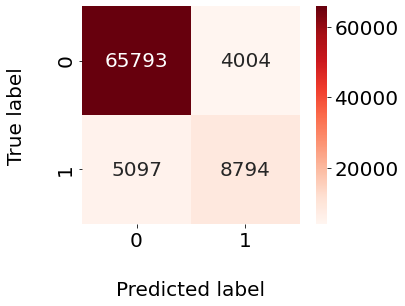

In [177]:
y_pred_keras = model.predict(dataset_X).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(encoded_Y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
xx=pd.DataFrame(y_pred_keras)
xx.columns=['predict_prob']
xx['target']=np.where(xx.predict_prob>0.5,1,0)
xx['y_actual']=encoded_Y
conf_matrix=confusion_matrix(xx.y_actual, xx.target)
df_conf_matrix = pd.DataFrame(conf_matrix, index=[0, 1], columns=[0, 1])
# Plot the confusion matrix (parameters are optimized for A4, 3 matrices in a row)
fig = plt.figure()
ax = fig.add_subplot(111)
fig = sns.heatmap(df_conf_matrix, annot=True, square=True, cmap='Reds',
fmt='d', annot_kws={"size": 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
ax.set_ylabel('True label', fontsize=20, labelpad=30)
ax.set_xlabel('Predicted label', fontsize=20, labelpad=30)
ax.tick_params(labelsize=20, axis='x')
ax.tick_params(labelsize=20, axis='y')
plt.show()

# Model 8: RNN with more epochs and focus on precision 

In [178]:
model1 = Sequential()
model1.add(Dense(1024, input_dim=8, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])

In [179]:
model1.fit(dataset_X, encoded_Y, epochs=30)

Epoch 1/30
2616/2616 [==============================] - 10s 4ms/step - loss: 0.5011 - precision_2: 0.5108
Epoch 2/30
2616/2616 [==============================] - 9s 4ms/step - loss: 0.5131 - precision_2: 0.5604
Epoch 3/30
2616/2616 [==============================] - 11s 4ms/step - loss: 0.2918 - precision_2: 0.6090
Epoch 4/30
2616/2616 [==============================] - 10s 4ms/step - loss: 0.2719 - precision_2: 0.6240
Epoch 5/30
2616/2616 [==============================] - 11s 4ms/step - loss: 0.2583 - precision_2: 0.6563
Epoch 6/30
2616/2616 [==============================] - 12s 5ms/step - loss: 0.2497 - precision_2: 0.6701
Epoch 7/30
2616/2616 [==============================] - 17s 6ms/step - loss: 0.2401 - precision_2: 0.6899
Epoch 8/30
2616/2616 [==============================] - 11s 4ms/step - loss: 0.2342 - precision_2: 0.7018
Epoch 9/30
2616/2616 [==============================] - 11s 4ms/step - loss: 0.2305 - precision_2: 0.7153
Epoch 10/30
2616/2616 [========================

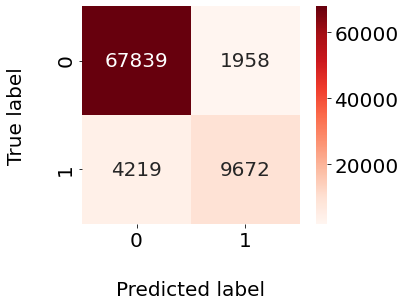

In [180]:
y_pred_keras = model1.predict(dataset_X).ravel()
xx=pd.DataFrame(y_pred_keras)
xx.columns=['predict_prob']
xx['target']=np.where(xx.predict_prob>0.5,1,0)
xx['y_actual']=pd.DataFrame(encoded_Y)
conf_matrix=confusion_matrix(xx.y_actual, xx.target)
df_conf_matrix = pd.DataFrame(conf_matrix, index=[0, 1], columns=[0, 1])

# Plot the confusion matrix (parameters are optimized for A4, 3 matrices in a row)
fig = plt.figure()
ax = fig.add_subplot(111)
fig = sns.heatmap(df_conf_matrix, annot=True, square=True, cmap='Reds',
fmt='d', annot_kws={"size": 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
ax.set_ylabel('True label', fontsize=20, labelpad=30)
ax.set_xlabel('Predicted label', fontsize=20, labelpad=30)
ax.tick_params(labelsize=20, axis='x')
ax.tick_params(labelsize=20, axis='y')
plt.show()

# ROC Curves

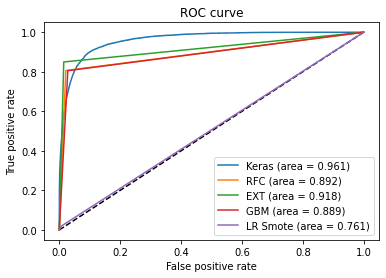

In [181]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_lr = logreg.predict(dataset_X).ravel()
fpr_lr, tpr_lr, thresholds_lr = roc_curve(encoded_Y, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)

y_pred_lr_s = lr_smote_tuned.predict(dataset_X).ravel()
fpr_lr_s, tpr_lr_s, thresholds_lr_s = roc_curve(encoded_Y, y_pred_lr_s)
auc_lr_s = auc(fpr_lr_s, tpr_lr_s)
 
y_pred_keras = model1.predict(dataset_X).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(encoded_Y, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

y_pred_rfc = gsRFC.best_estimator_.predict(dataset_X).ravel()
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(encoded_Y, y_pred_rfc)
auc_rfc = auc(fpr_rfc, tpr_rfc)

y_pred_ext = gsExtC.best_estimator_.predict(dataset_X).ravel()
fpr_ext, tpr_ext, thresholds_ext = roc_curve(encoded_Y, y_pred_ext)
auc_ext = auc(fpr_ext, tpr_ext)



y_pred_gbm = gsGBC.best_estimator_.predict(dataset_X).ravel()
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(encoded_Y, y_pred_gbm)
auc_gbm = auc(fpr_gbm, tpr_gbm)



plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rfc, tpr_rfc, label='RFC (area = {:.3f})'.format(auc_rfc))
plt.plot(fpr_ext, tpr_ext, label='EXT (area = {:.3f})'.format(auc_ext))
plt.plot(fpr_gbm, tpr_gbm, label='GBM (area = {:.3f})'.format(auc_gbm))
# plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.plot(fpr_lr, tpr_lr, label='LR Smote (area = {:.3f})'.format(auc_lr_s))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()